# Practical Introduction to Machine Learnig : Practical Session 2


<div class="alert alert-warning">
     <ul>
      zakaria echchair
    </ul>
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["image.cmap"] = "jet"
import jupyter_black

jupyter_black.load()
# plt.set_cmap('jet')

# Data visualization and pre-processing

In [11]:
data = np.load("ECoG.npz")

In [12]:
for item in data:
    print(item)

Yall
Fe
Xall


In [13]:
y = data["Yall"]
y

array([[-0.72565782],
       [-0.72219318],
       [-0.71872854],
       ...,
       [-0.37919401],
       [-0.35494155],
       [-0.33068908]])

In [14]:
data["Fe"]

array([[50]], dtype=uint8)

In [15]:
X = data["Xall"]
X.shape

(3327, 64)

In [16]:
X[:, 45].shape

(3327,)

<div >
     <ul>
      • Load the dataset in memory and plot the EcoG signals and the finger movement on the same figure (np.load,pl.plot,pl.subplot).
    </ul>
</div>

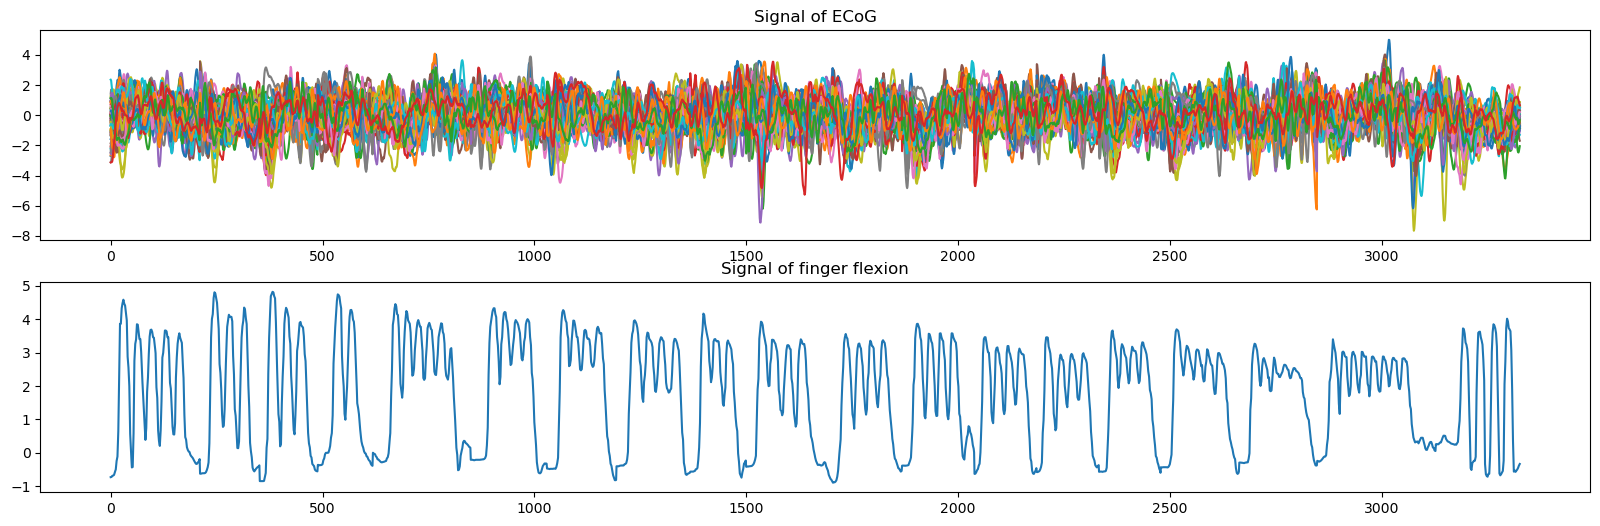

In [17]:
fig, ax = plt.subplots(2)
ax[0].plot(X)
ax[1].plot(y)
ax[0].set_title("Signal of ECoG")
ax[1].set_title("Signal of finger flexion");

## Visualisation 

<div >
     <ul>
      • Visualize the data as a scatter plot where the color of the samples is the value to predict y and their position are variables 45 and 48 of Xall (pl.scatter with Yall controlling the color).
    </ul>
</div>

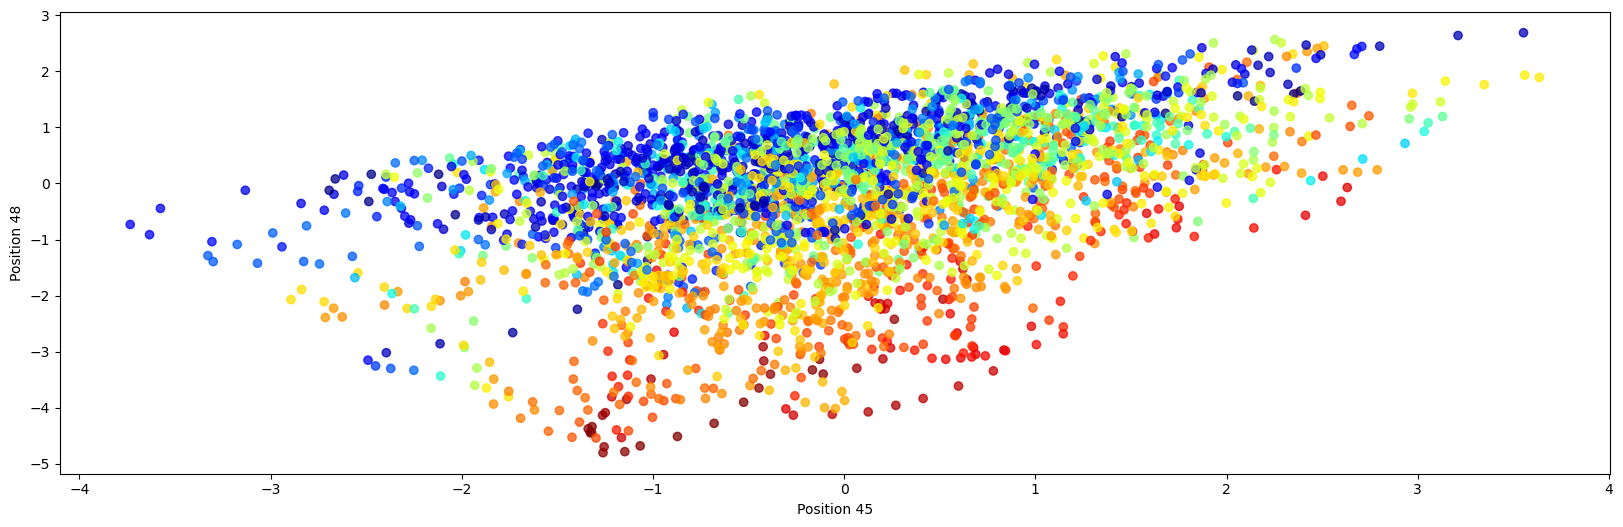

In [18]:
plt.figure()

plt.scatter(X[:, 45], X[:, 48], marker="o", c=y, linewidths=1, alpha=0.75)
plt.xlabel("Position 45")
plt.ylabel("Position 48")
plt.show();

<div >
     <ul>
      • Split the data in a training and a testing set with n = 1000 training samples and the remaining samples as testing samples (x=Xall[:n,:] to select the n first lines in a matrix).
    </ul>
</div>

In [19]:
n = 1000
Xtrain = X[:n, :]
ytrain = y[:n]

Xtest = X[n:, :]
ytest = y[n:]

# Least Squares regression (LS)

- Create the training matrix X̃ as defined in the course by concatenating a columns of 1s to the training
samples (np.concatenate,np.ones).

In [20]:
XtrainT = np.concatenate(((np.ones((n, 1))), Xtrain), axis=1)

In [21]:
teta = np.linalg.solve(XtrainT.T @ XtrainT, XtrainT.T @ ytrain)

In [22]:
w, b = teta[1:], teta[0]

In [23]:
ypred = Xtest @ w + b

In [24]:
ypredTrain = Xtrain @ w + b

In [25]:
len(ytrain)

1000

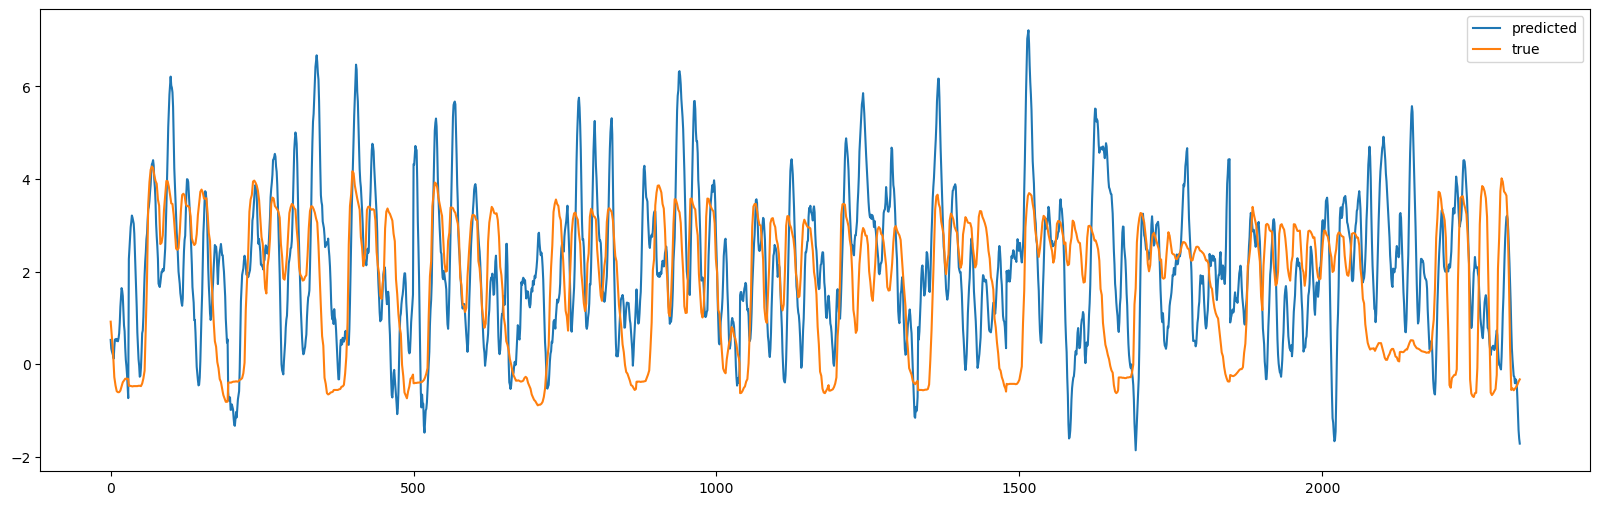

In [26]:
plt.plot(ypred, label="predicted")
plt.plot(ytest, label="true")
plt.legend();

The prediction on test data try took into consideration the input data, howwever, it's not good at all, especially because the training set size isn't enough to estimate the weight

In [27]:
def compute_r_squared(ypred, ytest, no_print=False):
    covM = np.cov(ypred, ytest)
    r = covM[1, 0] / np.sqrt(covM[1, 1] * covM[0, 0])
    r = r**2
    if not no_print:
        print(f" the R squared value is {r:.3f}")
    return r

In [28]:
def compute_MSE(ypred, ytest, no_print=False):
    mse = sum((ypred.flatten() - ytest.flatten()) ** 2) / len(ytest)
    if not no_print:
        print(f" the MSE value is {mse:.3f}")
    return mse

In [29]:
MSE_LS_test = compute_MSE(ypred.flatten(), ytest.flatten())
R_LS_test = compute_r_squared(ypred.flatten(), ytest.flatten())

 the MSE value is 3.046
 the R squared value is 0.127


In [31]:
print("for training set")
MSE_LS_train = compute_MSE(ypredTrain.flatten(), ytrain.flatten())
R_LS_train = compute_r_squared(ypredTrain.flatten(), ytrain.flatten())

for training set
 the MSE value is 0.504
 the R squared value is 0.840


<div >
     <ul>
      • Estimate a linear regression with sklearn.linear_model.LinearRegression and check that the estimated coefficients are the same as those estimated above (model.coef_,model.intercept_).
    </ul>
</div>

In [32]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(Xtrain, ytrain)
print(f"The Score of the model is  {reg.score(Xtest, ytest):2f}")

The Score of the model is  -0.428170


In [33]:
print(f"The equality between intercept values gives {np.allclose(reg.intercept_, b)}")

The equality between intercept values gives True


In [34]:
print(f"The equality between intercept values gives {np.allclose(reg.coef_, w.T)}")

The equality between intercept values gives True


# Ridge regression

Estimate the ridge predictor on the training data with λ = 1 and compute the prediction performances
on training and test set (sklearn.linear_model.Ridge).

In [35]:
from sklearn.linear_model import Ridge

In [36]:
ridgeM = Ridge(alpha=1).fit(Xtrain, ytrain)
ypred = ridgeM.predict(Xtest)
ypredTrain = ridgeM.predict(Xtrain)
print(f"The Score of the model for testing set is  {ridgeM.score(Xtest, ytest):2f}")
print(f"The Score of the model for training set is  {ridgeM.score(Xtrain, ytrain):2f}")

The Score of the model for testing set is  -0.408618
The Score of the model for training set is  0.839465


In [39]:
print("for testing set")
_ = compute_MSE(ypred.flatten(), ytest.flatten())
_ = compute_r_squared(ypred.flatten(), ytest.flatten())
print("for training set")
_ = compute_MSE(ypredTrain.flatten(), ytrain.flatten())
_ = compute_r_squared(ypredTrain.flatten(), ytrain.flatten())

for testing set
 the MSE value is 3.004
 the R squared value is 0.128
for training set
 the MSE value is 0.504
 the R squared value is 0.839


- Estimate the Ridge and, predict the labels and compute the performance for 100 values of the regu-
larization parameter λ from 10−3 to 105 .. Plot the evolution of the MSE on training and testing data
as a function of λ. Also plot the evolution of the linear parameters as a function of λ (in the same
figure with subplot).

In [40]:
lambda_values = np.linspace(1e-3, 1e5, 100)

In [41]:
def ridgeFit(alpha):
    ridgeM = Ridge(alpha=alpha).fit(Xtrain, ytrain)
    ypred = ridgeM.predict(Xtest)
    return (
        compute_MSE(ypred.flatten(), ytest.flatten(), True),
        ridgeM.coef_.flatten(),
        ridgeM,
    )

In [42]:
ridgeFitVectorised = np.vectorize(ridgeFit, otypes=[np.ndarray])
MSE_values, coefs, _ = list(map(list, zip(*ridgeFitVectorised(lambda_values))))

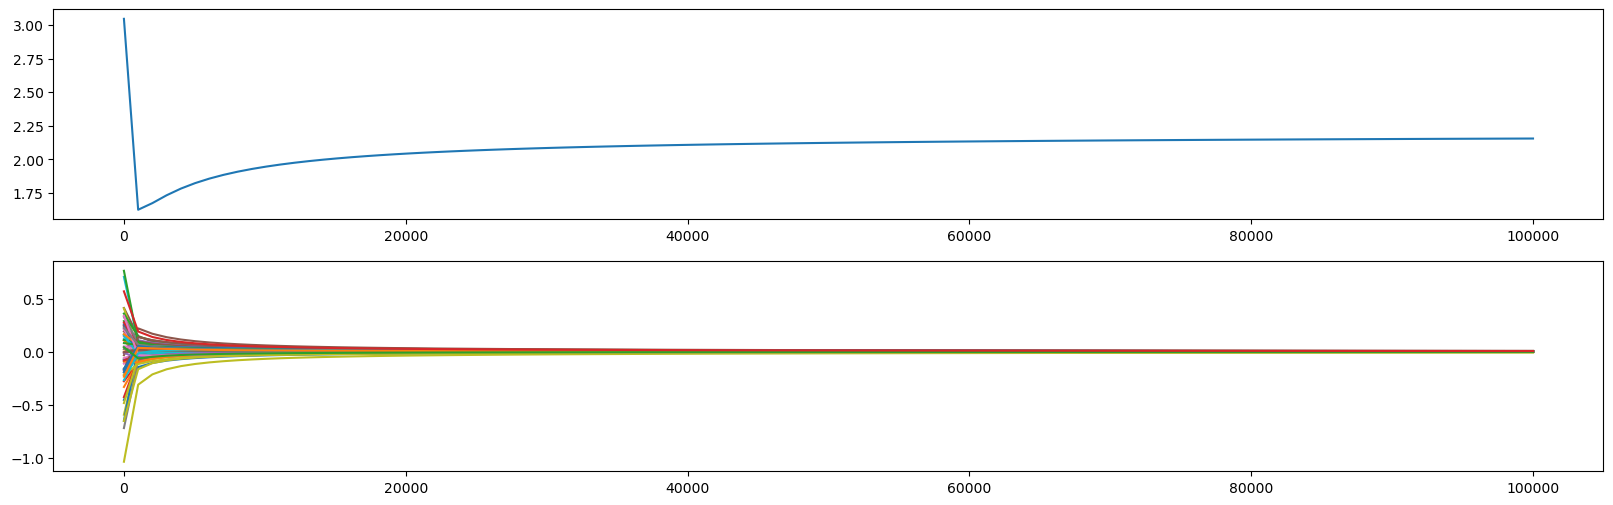

In [43]:
fig, ax = plt.subplots(2)
ax[0].plot(lambda_values, MSE_values)
ax[1].plot(lambda_values, np.vstack(coefs));

- Select the value of λ having the best performance on test data and estimate a Ridge model with this
λ (np.argmin).

In [44]:
bestLambda = lambda_values[np.argmin(MSE_values)]
bestLambda

1010.102

-  Predict the finger flexion of the subject on the training and test sets. Visualize with a scatter plot the
true values VS the predictions (pl.scatter).

In [45]:
ridgeM = Ridge(alpha=bestLambda).fit(Xtrain, ytrain)
ypred = ridgeM.predict(Xtest)
ypredTrain = ridgeM.predict(Xtrain)
print(f"The Score of the model for testing set is  {ridgeM.score(Xtest, ytest):2f}")
print(f"The Score of the model for training set is  {ridgeM.score(Xtrain, ytrain):2f}")

The Score of the model for testing set is  0.238189
The Score of the model for training set is  0.619335


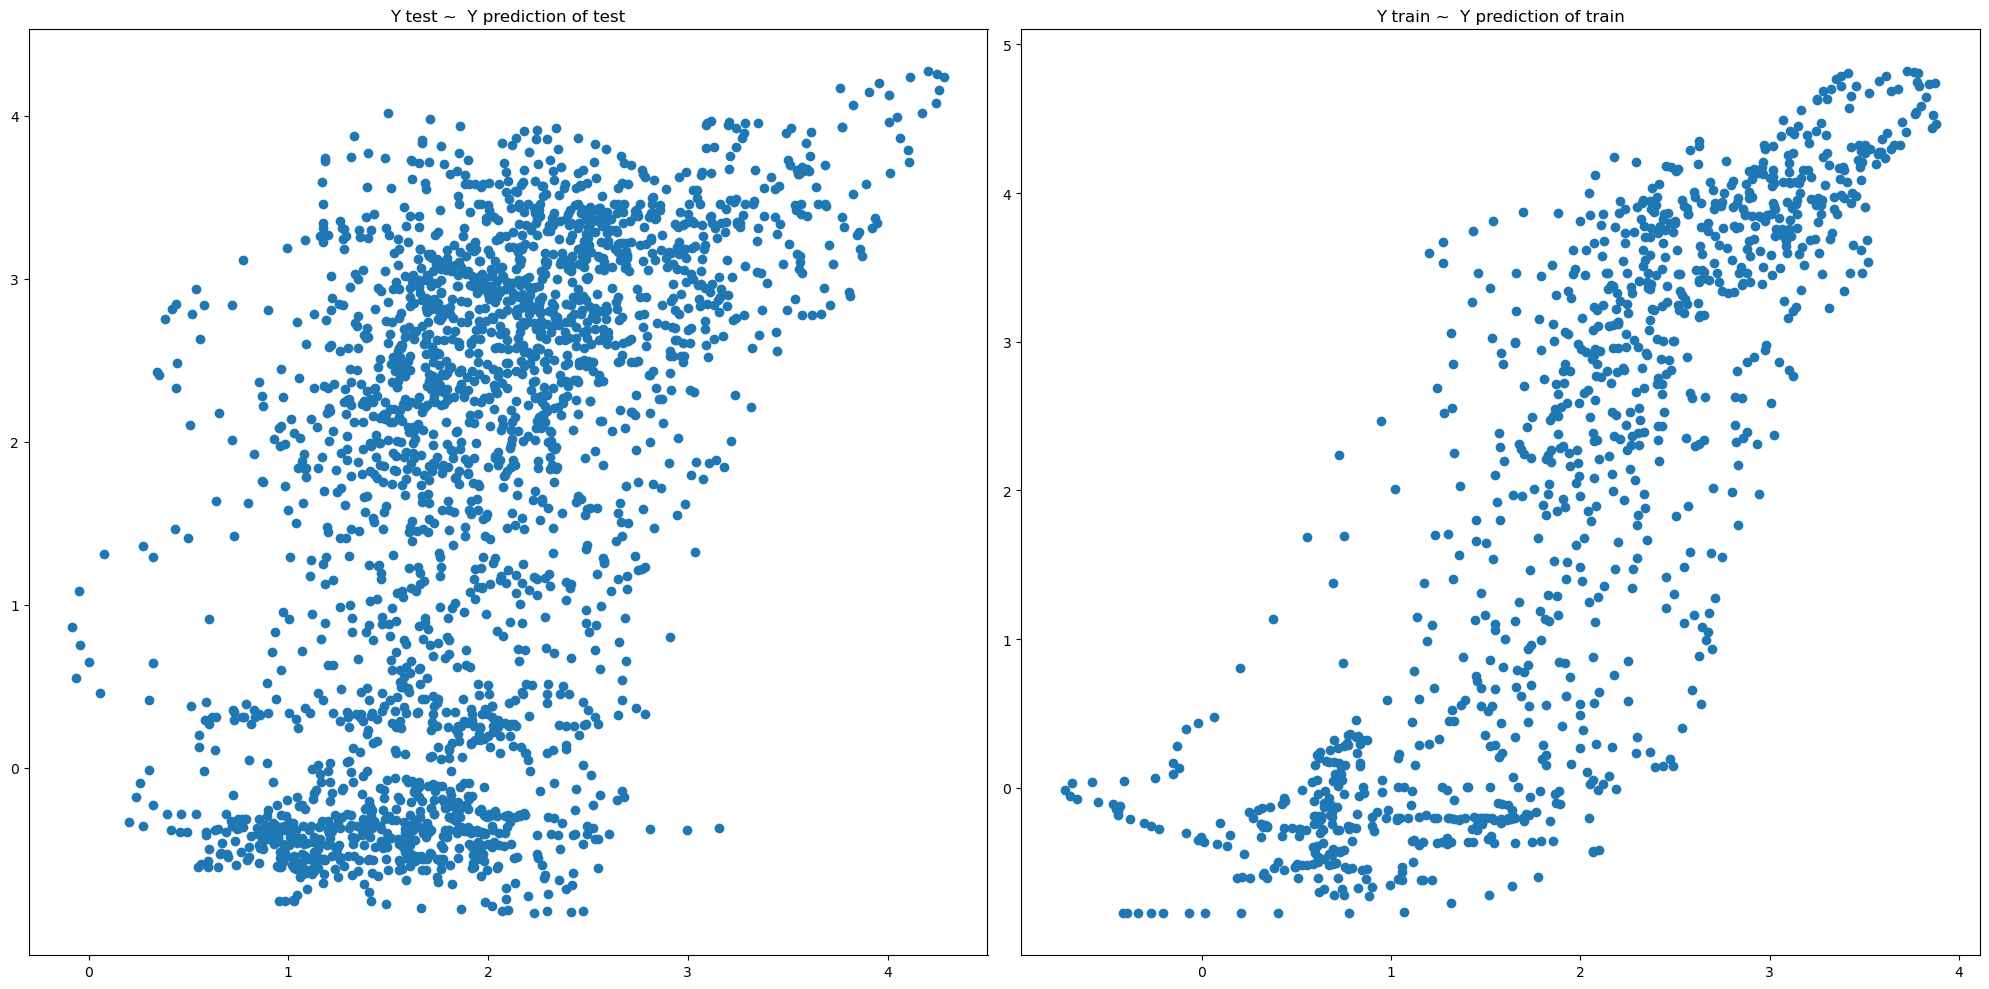

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plt.setp(ax, xticks=range(10), yticks=range(10))
ax[0].scatter(ypred, ytest)
ax[0].set_title("Y test ~  Y prediction of test")
ax[1].scatter(ypredTrain, ytrain)
ax[1].set_title("Y train ~  Y prediction of train")
fig.tight_layout();



we notice that the ratio between the true and predicted targets of training and testing are between 0 and 4, however it should be exactly 1, wich means that the model isn't very accurate 

- Plot the predictions along with the true y (pl.plot) as a function of time. Is the prediction good on
test data?

In [47]:
def plot_Sorted(yabs, yord):
    sortedTupples = sorted(zip(yabs, yord), key=lambda x: x[0])
    ytestSorted, ypredSorted = tuple(map(list, zip(*sortedTupples)))
    plt.plot(ytestSorted, ypredSorted)

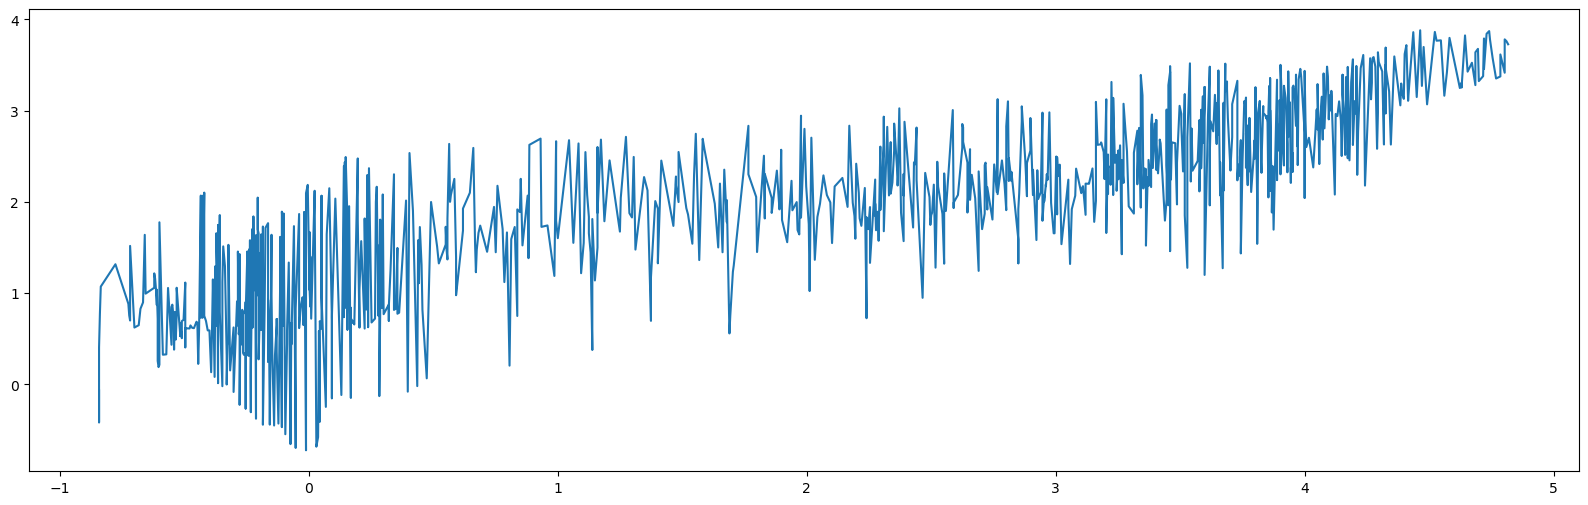

In [49]:
plot_Sorted(ytrain, ypredTrain)

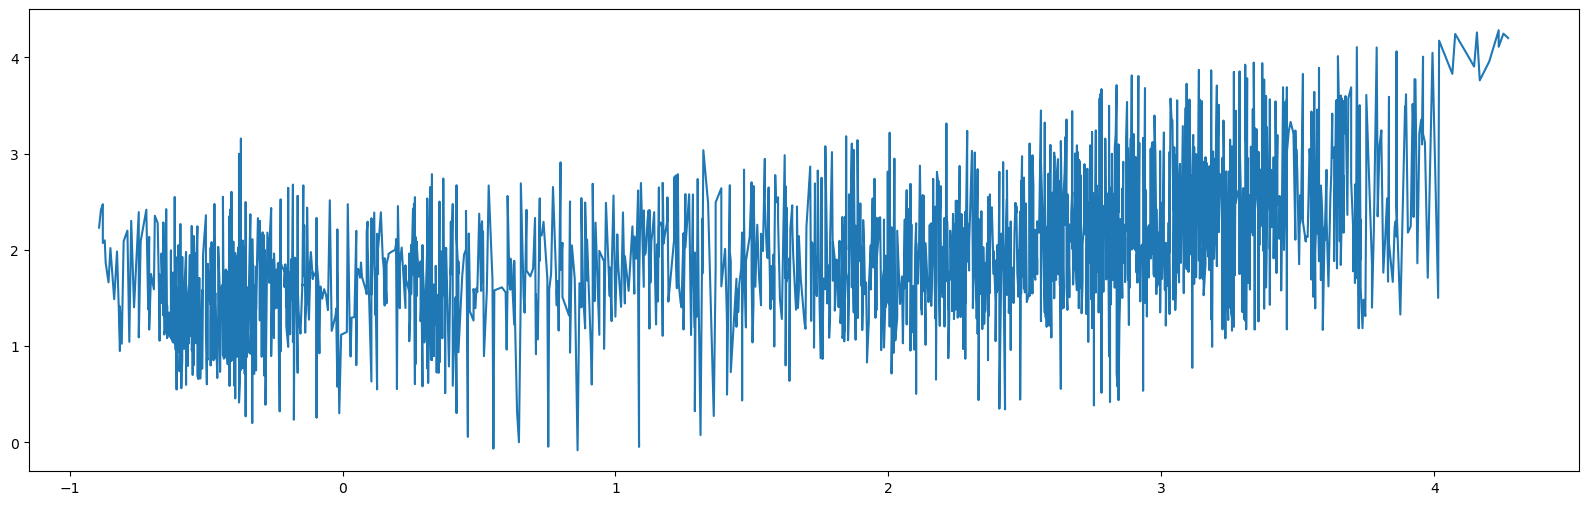

In [50]:
plot_Sorted(ytest, ypred)

when we plot sorted values, we notice that the model tend to maximaze the ratio of 1 , so it stays always around 1 , espeacilly between 1 and 3

As we can see from the results, the LS MSE in the testing set is larger than the Ridge MSE, and for the R-squared we see the opposite, R2_Ridge > R2_LS, but for the training set we see the opposite of all of this, meaning that there is some over-fitting in the training set.

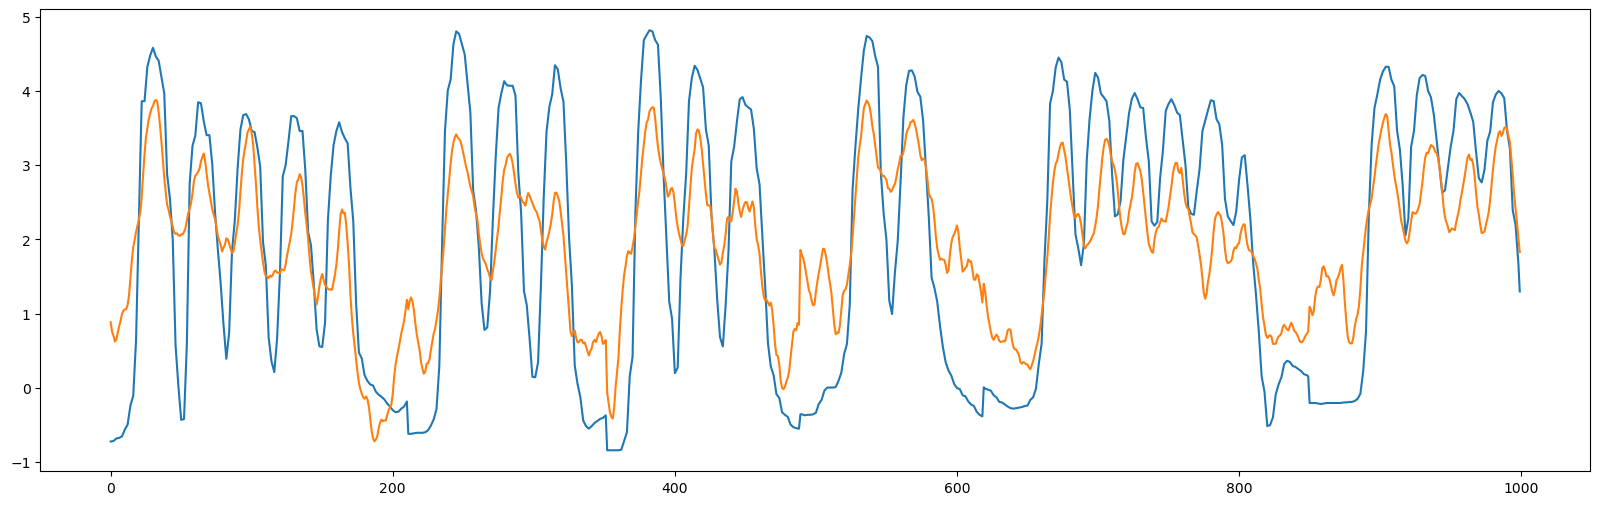

In [52]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ytrain)
plt.plot(ridgeM.predict(Xtrain))

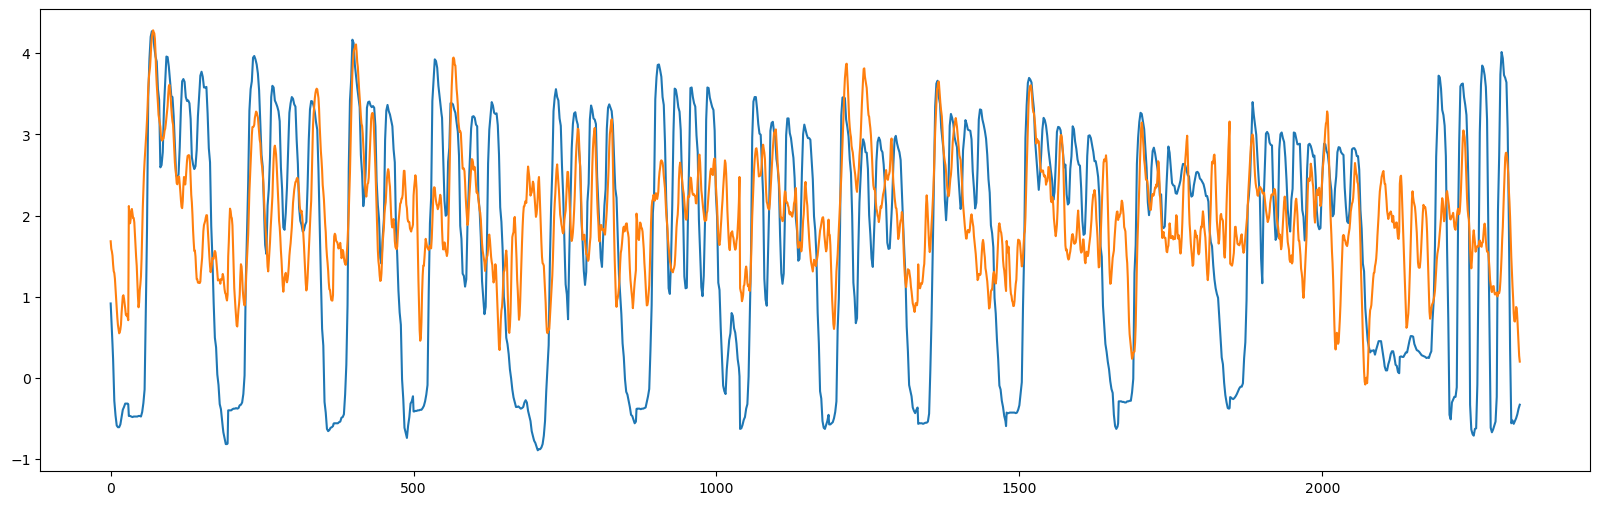

In [54]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ytest)
plt.plot(ridgeM.predict(Xtest));

we notice that the prediction aren't good on the testing set however they are very good for training set 

<div >
     <ul>
      • Compute the performance as MSE and R2 on training and test data. Compare with LS estimator and discuss.
    </ul>
</div>

In [57]:
print("************ for testing set ******************")
_ = compute_MSE(ypred.flatten(), ytest.flatten())
print(f"The MSE for LS is {MSE_LS_test:2f}")
_ = compute_r_squared(ypred.flatten(), ytest.flatten())
print(f"The R squared for LS is {R_LS_test:2f}")
# //////////////////////
print("\n*******************for training set*********************")
_ = compute_MSE(ypredTrain.flatten(), ytrain.flatten())
print(f"The MSE for LS is {MSE_LS_train:2f}")
_ = compute_r_squared(ypredTrain.flatten(), ytrain.flatten())
print(f"The R squared for LS is {R_LS_train:2f}")

************ for testing set ******************
 the MSE value is 1.625
The MSE for LS is 3.045537
 the R squared value is 0.273
The R squared for LS is 0.126578

*******************for training set*********************
 the MSE value is 1.196
The MSE for LS is 0.504065
 the R squared value is 0.697
The R squared for LS is 0.839500


As we can see from the results, the LS MSE in the test set is larger than the Ridge MSE and for R2 we see the opposite, R2_Ridge > R2_LS, but for the training set we see the opposite of all of this, meaning that there is some over fitting in the training set.

<div >
     <ul>
      • Interpret the classifiers w for both LS and Ridge estimator by plotting their values and their absolute values (pl.stem). Do they show the same important variables (large magnitude)?
    </ul>
</div>

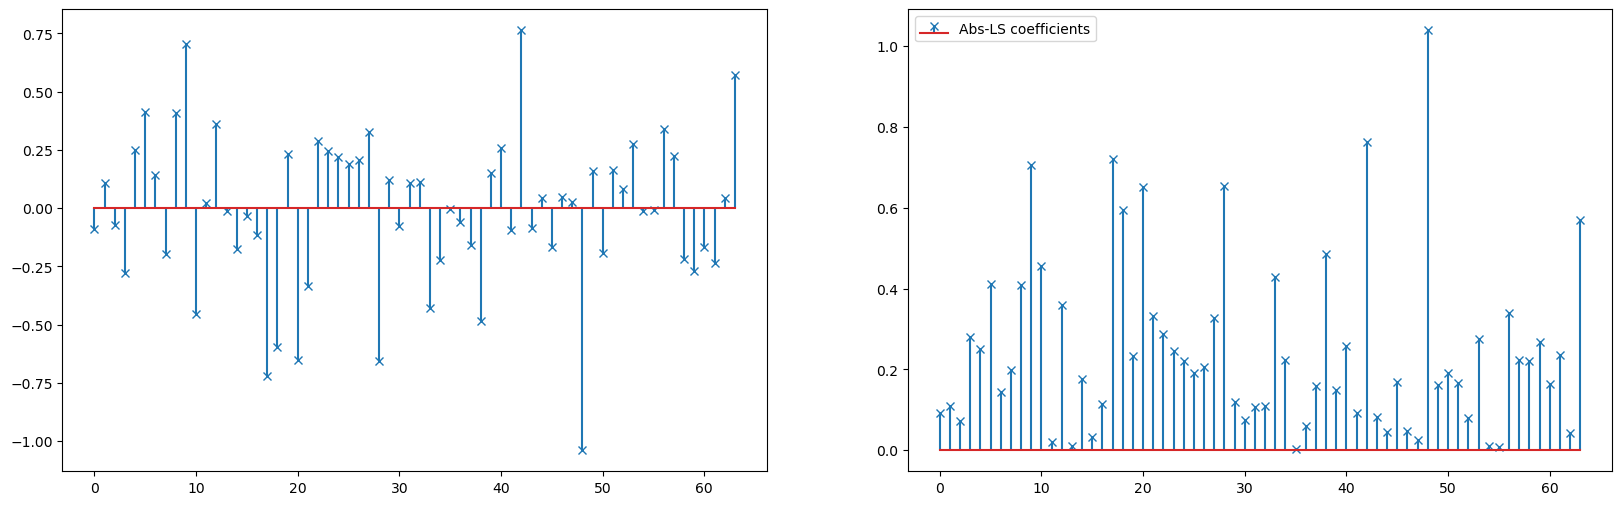

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].stem(
    np.where(reg.coef_.T)[0],
    reg.coef_[reg.coef_ != 0].T,
    markerfmt="x",
    label="LS coefficients",
    use_line_collection=True,
)
ax[1].stem(
    np.where(reg.coef_.T)[0],
    np.abs(reg.coef_[reg.coef_ != 0]).T,
    markerfmt="x",
    label="Abs-LS coefficients",
    use_line_collection=True,
)
plt.legend(loc="best")
plt.show()

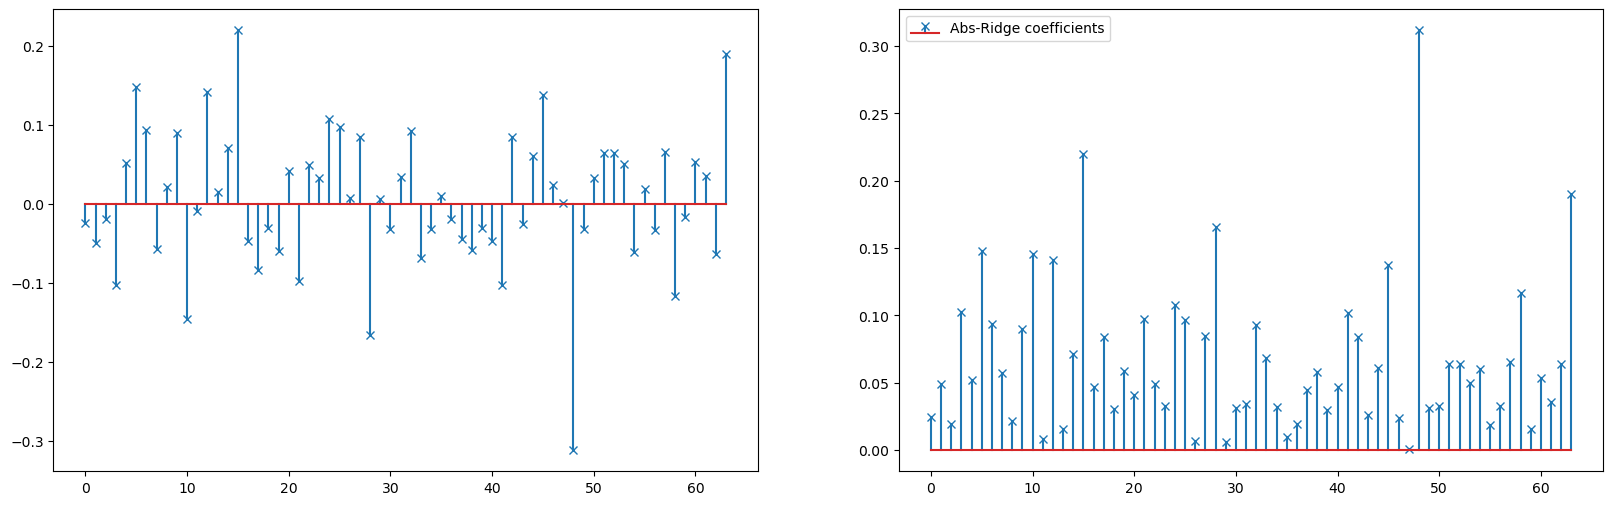

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].stem(
    np.where(ridgeM.coef_.T)[0],
    ridgeM.coef_[ridgeM.coef_ != 0].T,
    markerfmt="x",
    label="Ridge coefficients",
    use_line_collection=False,
)

ax[1].stem(
    np.where(ridgeM.coef_.T)[0],
    np.abs(ridgeM.coef_[ridgeM.coef_ != 0]).T,
    markerfmt="x",
    label="Abs-Ridge coefficients",
    use_line_collection=False,
)
plt.legend(loc="best")
plt.show()

The ridge model doesn't allow high values of coefficients, however it allows the pseudo null values to be greater

## Variable selection with the Lasso

<div >
     <ul>
      • Estimate the Lasso predictor on the training data with default value for the regularization parameter (sklearn.linear_model.Lasso).
    </ul>
</div>

In [60]:
from sklearn import linear_model

Lreg = linear_model.Lasso()
Lreg.fit(Xtrain, ytrain)
Lreg_pred = Lreg.predict(Xtest)

In [62]:
np.allclose(Lreg.coef_, 0)

True

We notice that the lasso coefficients are all null, because of the soft threshold phenomena. 

In [65]:
np.allclose(Lreg_pred, Lreg.intercept_)

True

as we discussed earlier , for a given lambda so high , we risk that all the coeffecients become null, then the predicted values of the model will be certainly the intercept.

So we suggest as a solution a smaller lambda value.

*for instance :*

In [66]:
def soft_thresholding(x, u):
    return (x - u) * (x > u) + (x + u) * (x < -u)

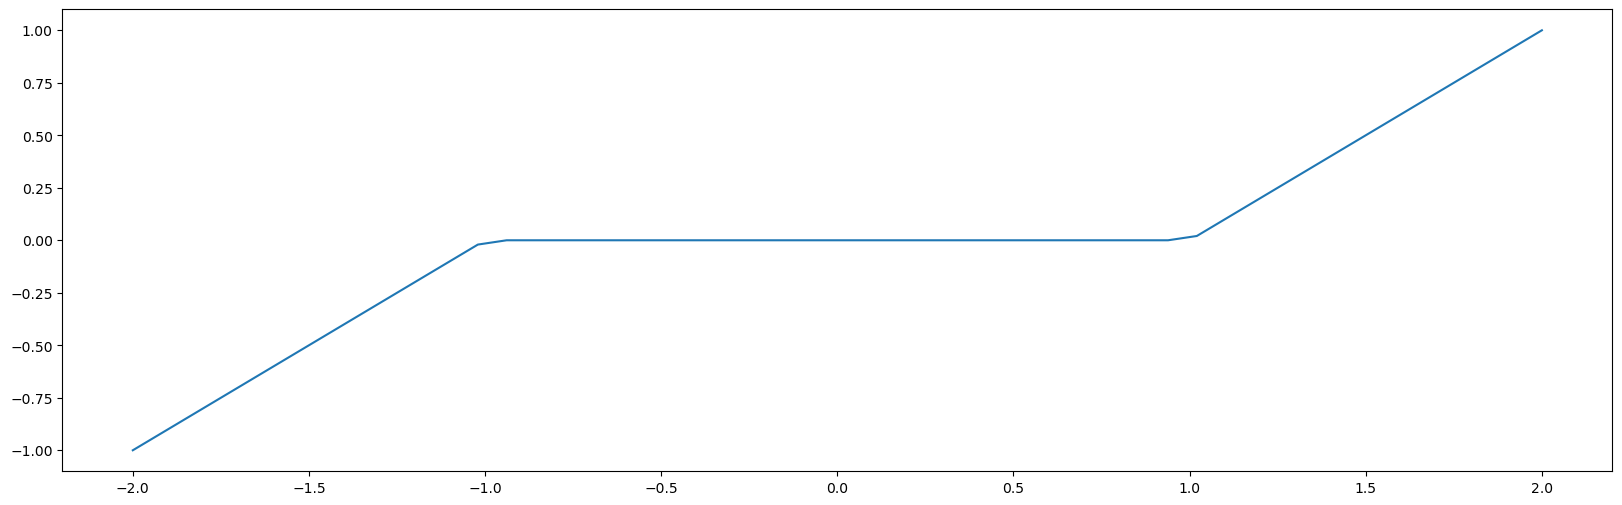

In [67]:
x = np.linspace(-2, 2)
plt.plot(x, soft_thresholding(x, 1));  # lmbda = 1

the figure above illustrate the impact of lambda on the model estimated coefficients


<div >
     <ul>
      • Estimate the Lasso and, predict the labels and compute the performance for 100 values of the regularization parameter λ from 10−3 to 10-5. (np.logspace,for i,reg in enumerate(lst_reg):). Plot the evolution of the MSE on training and testing data as a function of λ.
    </ul>
</div>

In [69]:
lst_MSE = []
lmbds = np.logspace(-3, 5, 100)
params = []

for i in lmbds:
    Lasso_model = linear_model.Lasso(alpha=i).fit(Xtrain, ytrain)
    lst_MSE.append(compute_MSE(Lasso_model.predict(Xtest), ytest, True))
    params.append(Lasso_model.coef_)
a = np.array(params)

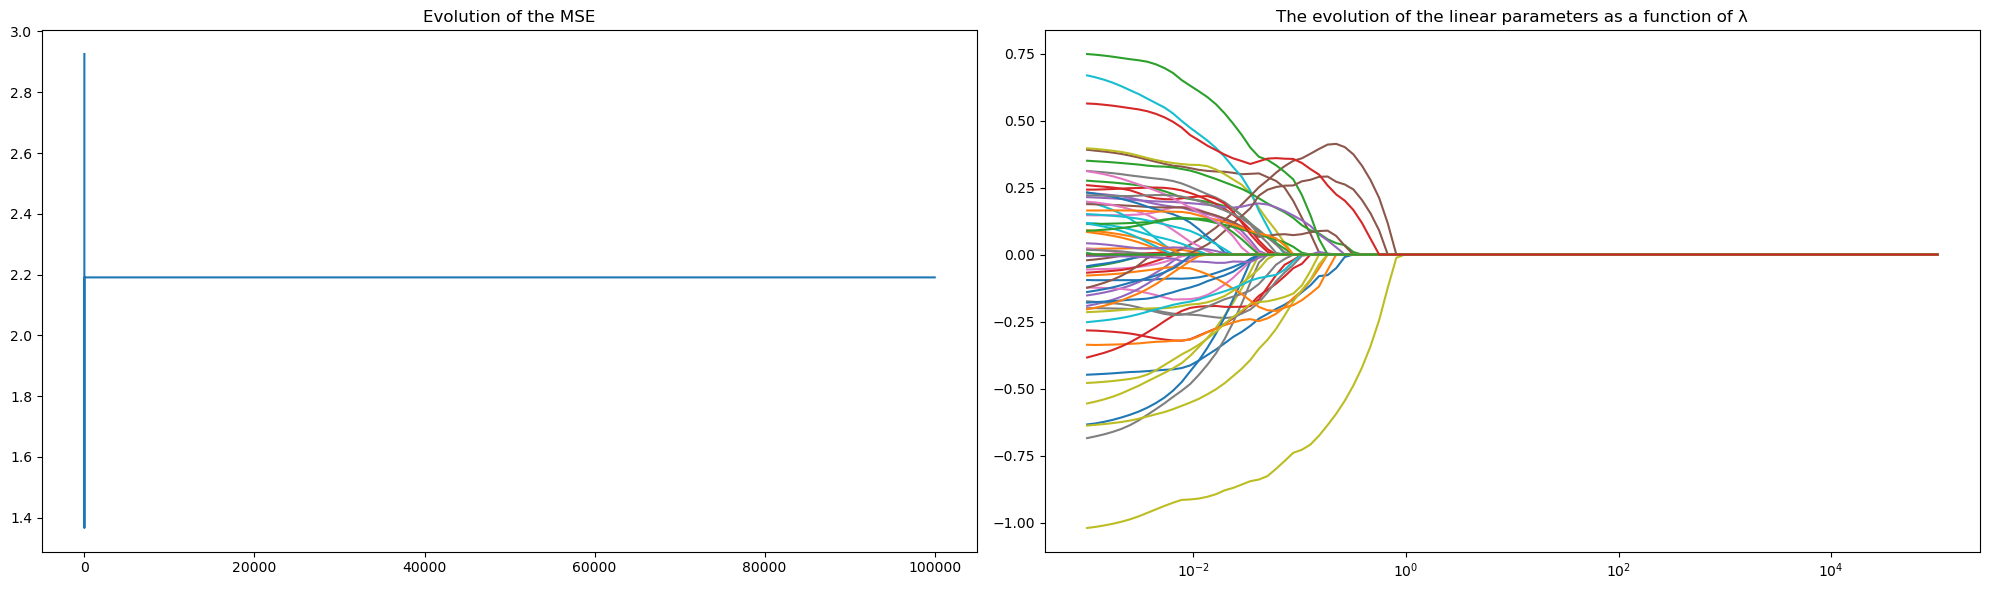

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(lmbds, lst_MSE)
axs[0].title.set_text("Evolution of the MSE")
for i in range(a.shape[1]):
    axs[1].plot(lmbds, a[:, i])
    axs[1].set_xscale("log")
axs[1].title.set_text("The evolution of the linear parameters as a function of λ")
plt.tight_layout()

Remember that if Lambda = 0, then the lasso gives the least squares fit, and when Lambda becomes very large, the lasso gives the null model in which all coefficient estimates equal zero.

Moving from left to right in our plot, we observe that at first the lasso models contains many predictors with high magnitudes of coefficient estimates. With increasing Lambda, the coefficient estimates approximate towards zero.

<div >
     <ul>
      • Select the value of λ having the best performance on test data and estimate a Lasso model with this λ (np.argmin).
    </ul>
</div>

In [78]:
print(f"the best lambda is: {lmbds[np.argmin(lst_MSE)]:.2f}")

the best lambda is: 0.13


In [80]:
Lasso = linear_model.Lasso(alpha=lmbds[np.argmin(lst_MSE)])
Lasso.fit(Xtrain, ytrain)

Lasso(alpha=0.1261856883066021)


<div >
     <ul>
      • Predict the finger flexion of the subject on the training and test sets. Plot the predictions along with the true y (pl.plot) as a function of time.
    </ul>
</div>

In [81]:
Lasso_pred = Lasso.predict(Xtest)
mse_lasso = compute_MSE(ytest, Lasso_pred)

 the MSE value is 1.366


**Testing set**

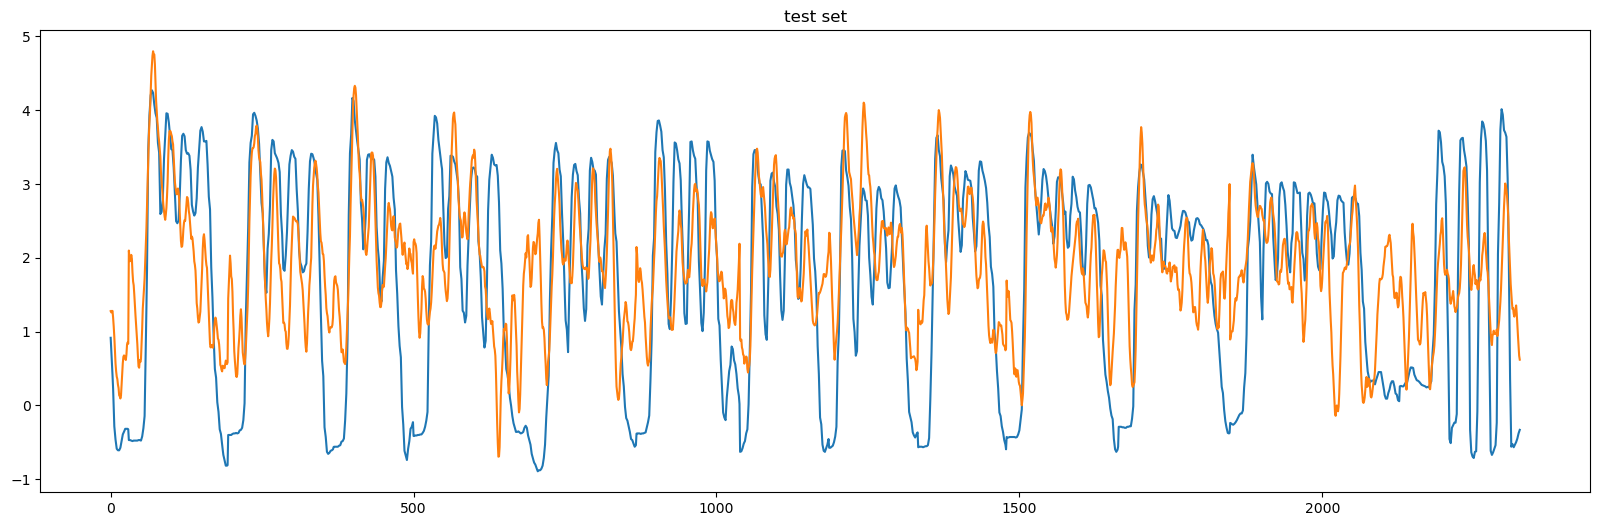

In [82]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ytest)
plt.plot(Lasso.predict(Xtest))
ax.title.set_text("test set")

**Training set**

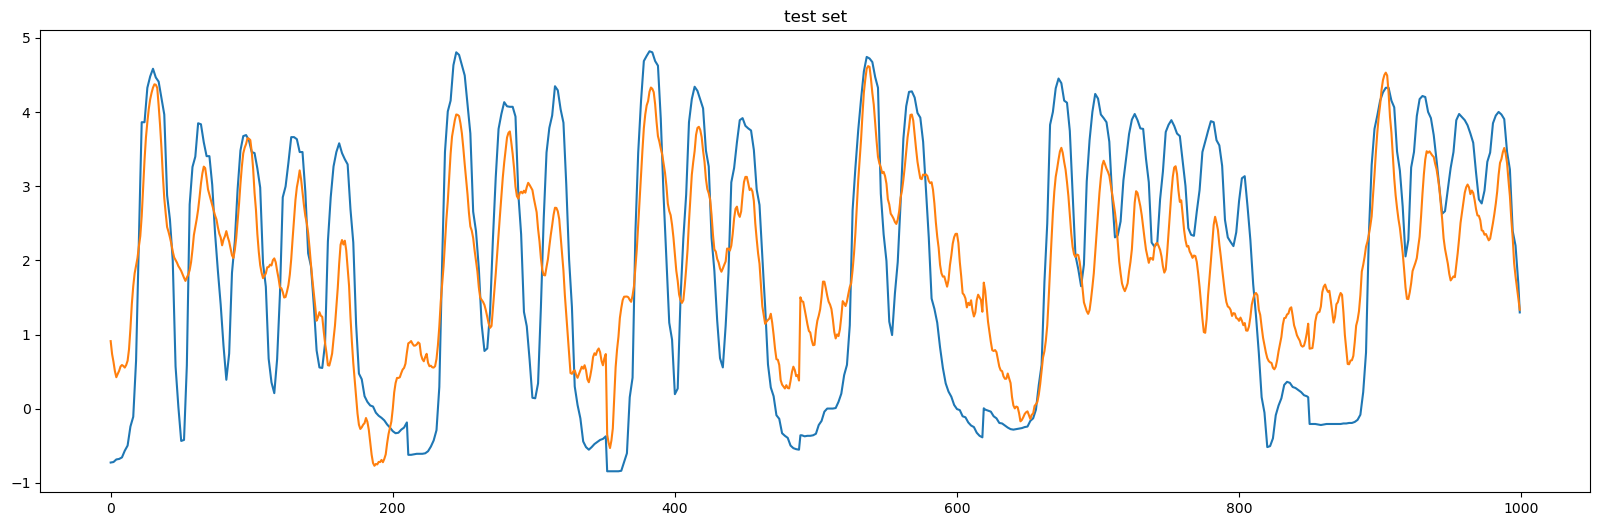

In [83]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ytrain)
plt.plot(Lasso.predict(Xtrain))
ax.title.set_text("test set")

As we can see the Lasso perform best in the testing set.

<div >
     <ul>
      • Interpret the classifiers w for the Lasso estimator by plotting their values and their absolute values (pl.stem). What are the two most important variables?
    </ul>
</div>

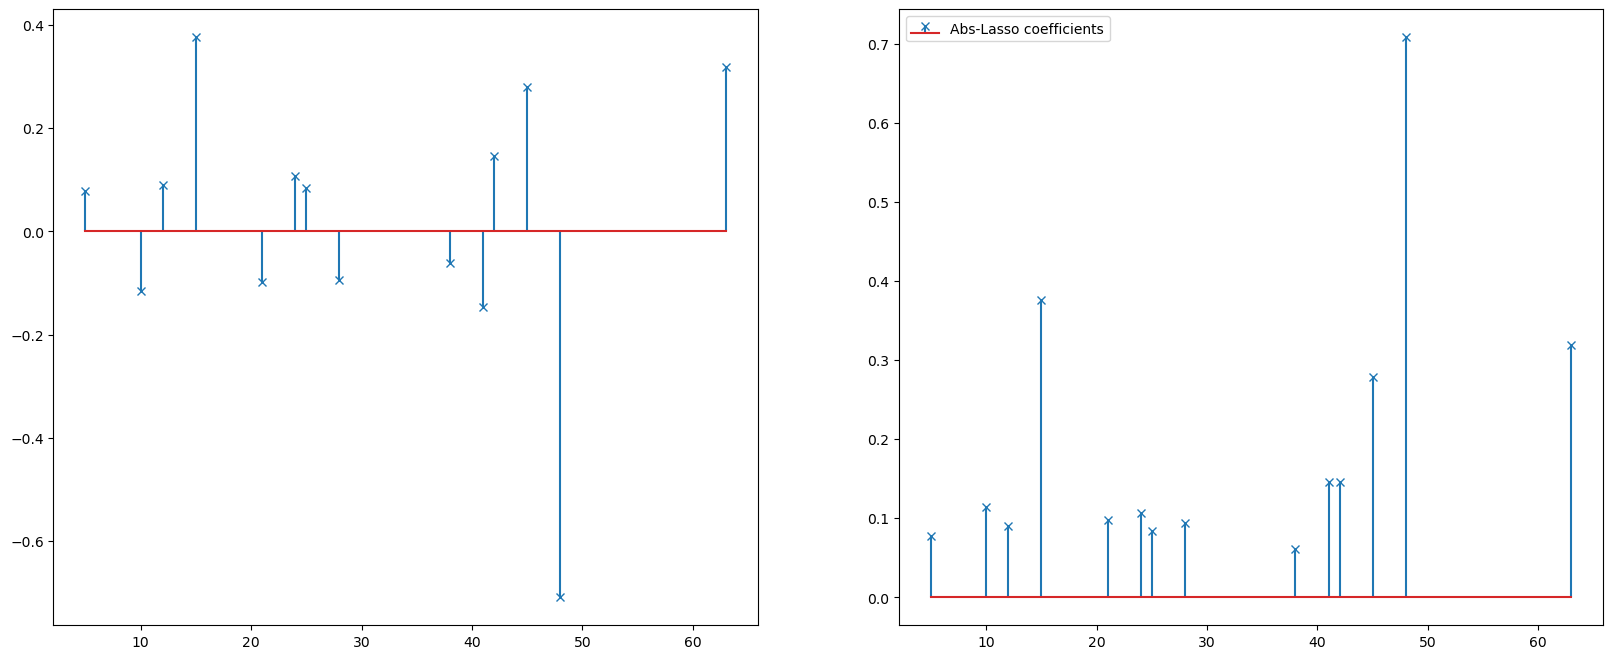

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].stem(
    np.where(Lasso.coef_)[0],
    Lasso.coef_[Lasso.coef_ != 0],
    markerfmt="x",
    label="Lasso coefficients",
    use_line_collection=True,
)
ax[1].stem(
    np.where(Lasso.coef_)[0],
    np.abs(Lasso.coef_[Lasso.coef_ != 0]),
    markerfmt="x",
    label="Abs-Lasso coefficients",
    use_line_collection=True,
)
plt.legend(loc="best")
plt.show()

In [85]:
np.argsort(np.abs(Lasso.coef_), axis=0)[-2:]

array([15, 48])

We notice that the two most important variables according to lasso feature selection are : **var 15** and **var 48**

##  Nonlinear regression


<div >
     <ul>
      • Fit the model with the default parameters and compute its prediction performance. Is it better than LS (that has no parameters), Ridge or Lasso estimators?
    </ul>
</div>

**Random Forest Regressor**

In [86]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
randomF = RandomForestRegressor()

In [90]:
randomF.fit(Xtrain, ytrain)

/tmp/ipykernel_6552/3871315232.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomF.fit(Xtrain, ytrain)


RandomForestRegressor()

Now, we can predict the test data by using the trained model. We can check the accuracy of predicted data by using MSE

In [92]:
ypred = randomF.predict(Xtest)
mse_rf = compute_MSE(ytest, ypred)

 the MSE value is 1.627


**SVM**

In [94]:
from sklearn.svm import SVR

In [95]:
svrModel = SVR()
svrModel.fit(Xtrain, ytrain)

/home/zechchair/anaconda3/envs/practicalIntro/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [97]:
ypred = svrModel.predict(Xtest)
mse_svm = compute_MSE(ytest, ypred)

 the MSE value is 1.515


**MLPRegressor**

In [98]:
from sklearn.neural_network import MLPRegressor

In [99]:
mlpModel = MLPRegressor().fit(Xtrain, ytrain)

/home/zechchair/anaconda3/envs/practicalIntro/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [100]:
ypred = mlpModel.predict(Xtest)
mse_mlp = compute_MSE(ytest, ypred)

 the MSE value is 2.291


**Gradient Boosting Regressor**

In [101]:
from sklearn.ensemble import GradientBoostingRegressor

In [102]:
GradientBoosting = GradientBoostingRegressor(random_state=0)
GradientBoosting.fit(Xtrain, ytrain)
GradientBoosting.predict(Xtest)

/home/zechchair/anaconda3/envs/practicalIntro/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1.23620812, 1.64367766, 1.52564845, ..., 1.19734115, 1.14874838,
       1.07174643])

In [103]:
ypred = GradientBoosting.predict(Xtest)
mse_GBR = compute_MSE(ytest, ypred)

 the MSE value is 1.685


In [104]:
model_performances = pd.DataFrame(
    {
        "Model": [
            "LS",
            "Ridge",
            "Lasso",
            "Random Forest Regressor",
            "SVM.svrModel",
            "MLPRegressor",
            "Gradient Boosting Regression",
        ],
        "MSE": [
            str(MSE_LS_test)[0:8],
            str(compute_MSE(ypred, ytest))[0:8],
            str(mse_lasso)[0:8],
            str(mse_rf)[0:8],
            str(mse_svm)[0:8],
            str(mse_mlp)[0:8],
            str(mse_GBR)[0:8],
        ],
    }
)
model_performances.round(4)

print("Sorted by MSE in testing set:")
model_performances.sort_values(by="MSE")

 the MSE value is 1.685
Sorted by MSE in testing set:


Model       MSE
2                         Lasso  1.365954
4                  SVM.svrModel  1.515182
3       Random Forest Regressor  1.626518
1                         Ridge  1.685022
6  Gradient Boosting Regression  1.685022
5                  MLPRegressor  2.291282
0                            LS  3.045536

As we can see, the best model is the Lasso, with the svrModel coming in second then the MLPRegressor and the LS in the last position.

<div >
     <ul>
      • Validate (by hand, or with a loop) some of the important parameters in order to maximize the performance on test. Is the performance very dependent on the parameters?
    </ul>
</div>

**Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_distributions = {
    "max_features": [1, 2, 3, 5, None],
    "max_leaf_nodes": [10, 100, 1000, None],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
}
search_cv = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2),
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_error",
    n_iter=10,
    random_state=0,
    n_jobs=-1,
)
search_cv.fit(Xtrain, ytrain)

In [106]:
rf_pred = search_cv.predict(Xtest)
mse_rf = compute_MSE(ytest, rf_pred)

 the MSE value is 1.710


**SVM**

In [ ]:
from sklearn.svm import svrModel

In [ ]:
svrModel = svrModel(C=0.6,epsilon=1e-3)
svrModel.fit(Xtrain,ytrain)

SVR(C=0.6, epsilon=0.001)

In [107]:
svr_pred = svrModel.predict(Xtest)
mse_svm = compute_MSE(ytest, svr_pred)

 the MSE value is 1.515


**MLPRegressor**

In [108]:
from sklearn.neural_network import MLPRegressor

In [109]:
randomF.fit(Xtrain, ytrain)

/home/zechchair/anaconda3/envs/practicalIntro/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor()

In [110]:
mlp_pred = randomF.predict(Xtest)
mse_mlp = compute_MSE(ytest, mlp_pred)
print("MSE: ", mse_mlp)

 the MSE value is 2.529
MSE:  2.5285277514788946


**Gradient Boosting Regressor**

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [115]:
parameters = {
    "learning_rate": [0.01, 0.02, 0.03, 0.04],
    "subsample": [0.9, 0.5, 0.2, 0.1],
    "n_estimators": [100, 500, 1000, 1500],
    "max_depth": [4, 6, 8, 10],
}

In [116]:
GBR = GradientBoostingRegressor()

In [117]:
grid_GBR = GridSearchCV(estimator=GBR, param_grid=parameters, cv=2, n_jobs=-1)
grid_GBR.fit(Xtrain, ytrain)

/home/zechchair/anaconda3/envs/practicalIntro/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zechchair/anaconda3/envs/practicalIntro/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zechchair/anaconda3/envs/practicalIntro/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01]})

In [118]:
print(" Results from Grid Search ")
print("\n The best estimator across ALL searched params:\n", grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01)

 The best score across ALL searched params:
 0.22971493912708396

 The best parameters across ALL searched params:
 {'learning_rate': 0.01}


In [119]:
gbr_pred = reg.predict(Xtest)
mse_GBR = compute_MSE(ytest, gbr_pred)

 the MSE value is 3.046


In [120]:
model_performances = pd.DataFrame(
    {
        "Model": [
            "LS",
            "Ridge",
            "Lasso",
            "Random Forest Regressor",
            "SVM.svrModel",
            "MLPRegressor",
            "Gradient Boosting Regression",
        ],
        "MSE": [
            str(MSE_LS_test)[0:8],
            str(compute_MSE(ypred, ytest))[0:8],
            str(mse_lasso)[0:8],
            str(mse_rf)[0:8],
            str(mse_svm)[0:8],
            str(mse_mlp)[0:8],
            str(mse_GBR)[0:8],
        ],
    }
)
model_performances.round(4)

print("Sorted by MSE in testing set by tunning some params:")
model_performances.sort_values(by="MSE")

 the MSE value is 1.685
Sorted by MSE in testing set by tunning some params:


Model       MSE
2                         Lasso  1.365954
4                  SVM.svrModel  1.515182
1                         Ridge  1.685022
3       Random Forest Regressor  1.710089
5                  MLPRegressor  2.528527
0                            LS  3.045536
6  Gradient Boosting Regression  3.045536

The performance is not very dependent on the parameters, there is a little bit change

<div >
     <ul>
      • Plot the predictions along with the true y (pl.plot) as a function of time. Is the regression method good and why?
    </ul>
</div>

**Rforest**

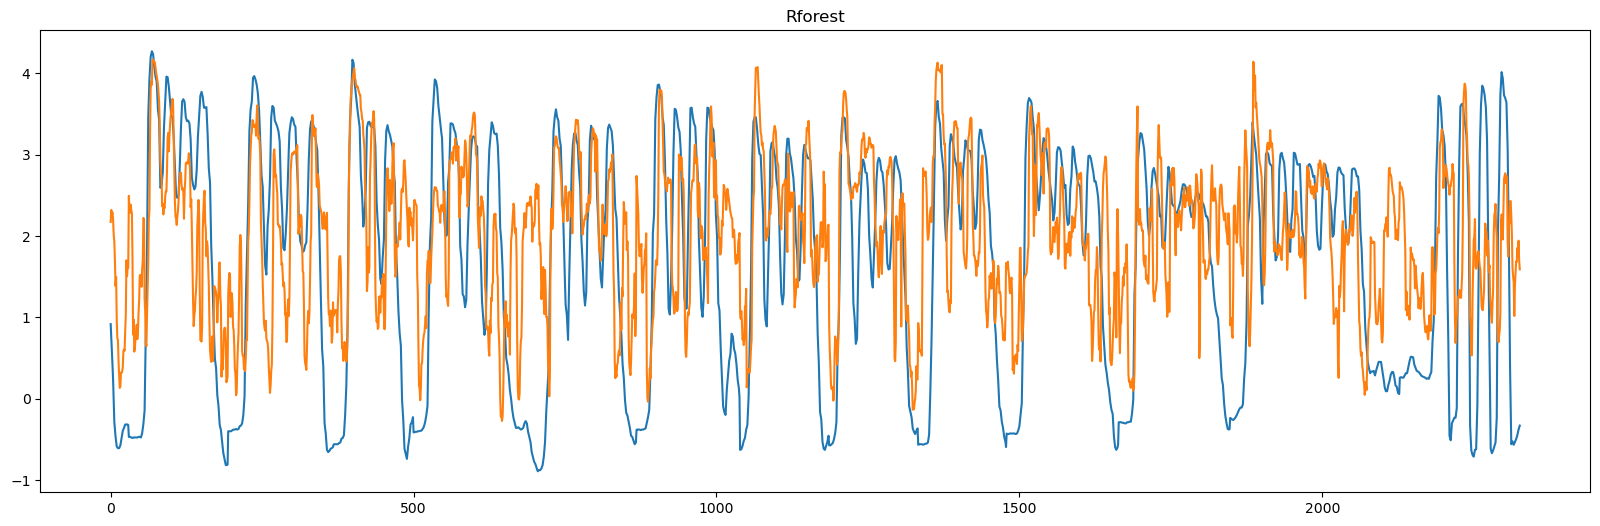

In [121]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ytest)
plt.plot(rf_pred)
ax.title.set_text("Rforest")

**SVM_SVR**

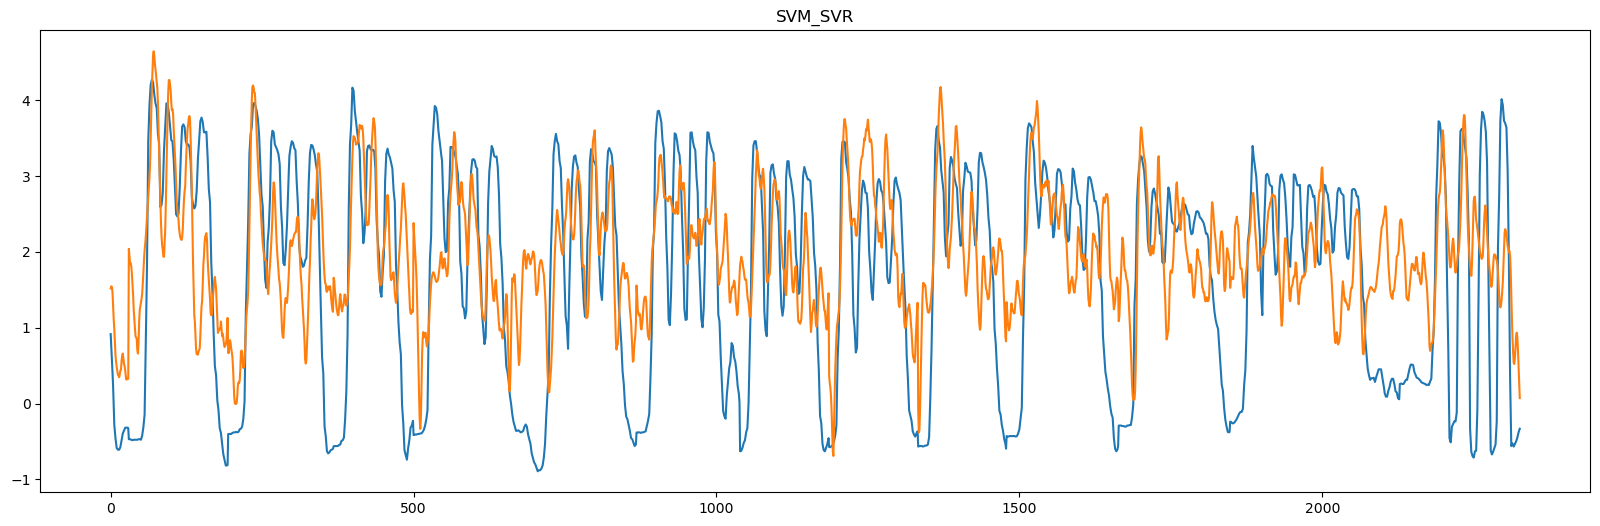

In [122]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ytest)
plt.plot(svr_pred)
ax.title.set_text("SVM_SVR")

**MLPRegressor**

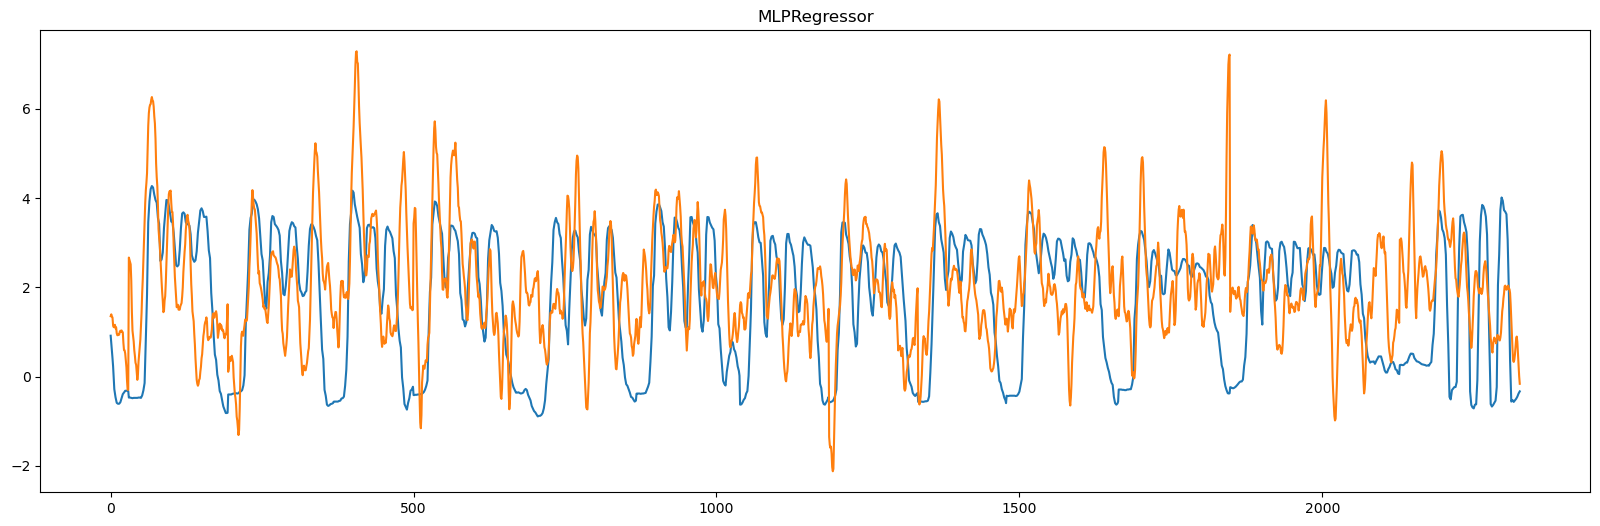

In [123]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ytest)
plt.plot(mlp_pred)
ax.title.set_text("MLPRegressor")

**Gradient Boosting Regression**

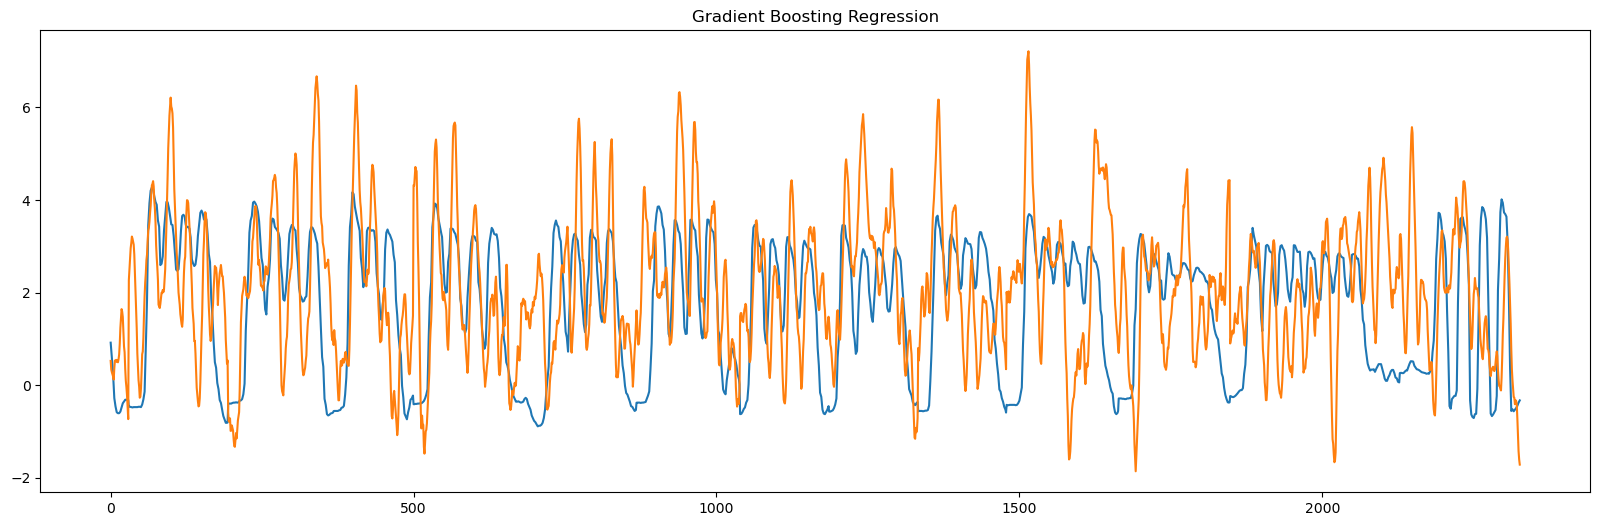

In [124]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ytest)
plt.plot(gbr_pred)
ax.title.set_text("Gradient Boosting Regression")

Regression is a reliable method of identifying which variables have impact on a topic of interest. The process of performing a regression allows us to confidently determine which factors matter most, which factors can be ignored, and how these factors influence each other.

##  Final comparison of the performances


<div >
     <ul>
      • Collect the test performances for all methods investigated above in a table (in a dataframe and printing it for instance). Which methods work the best in practice?
    </ul>
</div>

In [125]:
model_performances = pd.DataFrame(
    {
        "Model": [
            "LS",
            "Ridge",
            "Lasso",
            "Random Forest Regressor",
            "SVM.svrModel",
            "MLPRegressor",
            "Gradient Boosting Regression",
        ],
        "MSE": [
            str(MSE_LS_test)[0:8],
            str(compute_MSE(ypred, ytest))[0:8],
            str(mse_lasso)[0:8],
            str(mse_rf)[0:8],
            str(mse_svm)[0:8],
            str(mse_mlp)[0:8],
            str(mse_GBR)[0:8],
        ],
    }
)
model_performances.round(4)

print("Sorted by MSE in testing set by tunning some params:")
model_performances.sort_values(by="MSE")

 the MSE value is 1.685
Sorted by MSE in testing set by tunning some params:


Model       MSE
2                         Lasso  1.365954
4                  SVM.svrModel  1.515182
1                         Ridge  1.685022
3       Random Forest Regressor  1.710089
5                  MLPRegressor  2.528527
0                            LS  3.045536
6  Gradient Boosting Regression  3.045536

The best method is Lasso regression followed by ridge regression and SVM Regressor, especially that the lasso allows to make a selection of the features.

<div >
     <ul>
      • What are the most interpretable models?
    </ul>
</div>

Regression analysis tells you which predictors in a model are statistically significant and which are not. This makes linear regression models more relevant for analysis and interpretability.

<div >
     <ul>
      • Which model is best from a medical/practical perspective?
    </ul>
</div>

Apart from the performance of the Lasso regression, it is more interesting because it allows researchers to determine the regions responsible for the finger response.

<div >
     <ul>
      • Do we need non-linearity in this application?
    </ul>
</div>

Since we are dealing with data that is random, which is predicated on the human brain, this will lead us to use methods that are not linear, which is another reason why our models do not perform well.

<div >
     <ul>
      • Is validation on the test data a good practice? What would you do if you need to provide a model to a client for prediction in production?
    </ul>
</div>

Validation dataset: This sample of data is used to provide an unbiased assessment of the performance of a model on the training dataset while adjusting the model hyperparameters. The evaluation becomes more biased when the sensitivity of the validation dataset is incorporated into the model setup.

On the other hand, the test dataset: The sample of data used to provide an unbiased evaluation of the performance of a final model on the training dataset.

In order to deliver a model for production to a customer, I will have to split my data set on three data sets (training, validation, testing sets) to guarantee the robustness of the model. Moreover, on the selection of features I will have to compare the results obtained with the business.

##### Conclusion

- This work was very structured in order to have all the important notions of regression.
- The reg models are not the best choice in this case.